In [1]:
folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/'

import numpy as np
#import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import sys
np.set_printoptions(threshold=sys.maxsize)

from scipy import io
from scipy import stats
import pickle
import time
import pandas as pd

#Import function to get the covariate matrix that includes spike history from previous bins
import sys
sys.path.append(folder+"handy_functions") # go to parent dir
from preprocessing_funcs import get_spikes_with_history

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import WienerCascadeDecoder
from decoders import WienerFilterDecoder
from decoders import DenseNNDecoder
from decoders import SimpleRNNDecoder
from decoders import GRUDecoder
from decoders import LSTMDecoder
from decoders import XGBoostDecoder
from decoders import SVRDecoder
from sklearn import linear_model #For Wiener Filter and Wiener Cascade
from sklearn.svm import SVR #For support vector regression (SVR)
from sklearn.svm import SVC #For support vector classification (SVM)
from bayes_opt import BayesianOptimization

In [6]:
with open(folder+'datasets/vars-pa29dir4A-pre500-post300-dt50.pickle','rb') as f:
    neural_data,out_binned=pickle.load(f,encoding='latin1')

with open(folder+'runs/s0-t0-d50-m3-o0-nm24-nf41-r1-bn0.pickle','rb') as f:
    y_train,y_valid,y_test,y_train_pred,y_valid_pred,y_test_pred,R2s,rhos,time_elapsed=pickle.load(f,encoding='latin1')

units = pd.read_csv(folder+'datasets/units-pa29dir4A-pre500-post300.csv') 
units

,UnitName,BrainArea,SNR,BestDir,MeanFR_BestDir,VarFR_BestDir
0,unit001a,FEF,1.223093,145,74.092050,429.056499
1,unit002a,FEF,2.672726,145,42.000000,429.056499
2,unit002b,FEF,1.193786,145,88.242678,429.056499
3,unit003c,FEF,1.069769,145,121.707113,429.056499
4,unit004a,FEF,2.073657,415,8.297189,1269.364771
...,...,...,...,...,...,...
60,unit052a,MT,0.886098,145,98.577406,429.056499
61,unit053a,MT,1.364443,145,94.803347,429.056499
62,unit054a,MT,1.125868,145,91.071130,429.056499
63,unit055a,MT,1.260755,145,24.577406,429.056499


Text(0.5, 1.0, '[0.49168009 0.37219751 0.3980999 ]')

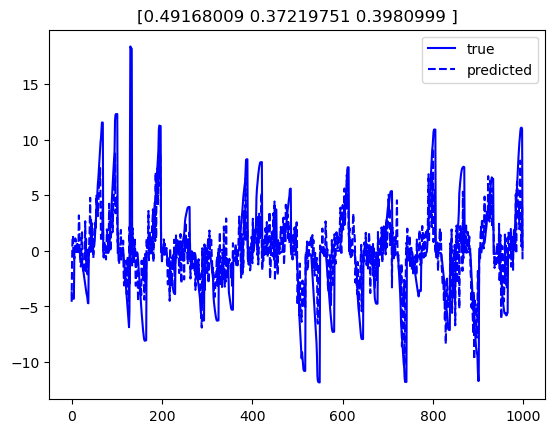

In [18]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

plt.plot(y_train[0][1:1000,0],label='true',color='blue',linestyle='solid')
plt.plot(y_train_pred[0][1:1000,0],label='predicted',color='blue',linestyle='dashed')
plt.legend() 
plt.title(R2s[0])

In [19]:
print('MT Neurons:',len(units.loc[units['BrainArea'] == 'MT']))
print('FEF Neurons:',len(units.loc[units['BrainArea'] == 'FEF']))

sorted(np.random.choice(units[units['BrainArea'] == 'MT'].index, 20, replace=False))
#sorted(np.random.choice(units[units['BrainArea'] == 'FEF'].index, 41, replace=False))
#units[units['BrainArea'] == 'MT'].index

MT Neurons: 24
FEF Neurons: 41


[42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 60,
 61,
 62,
 63,
 64]

In [20]:
mt_inds = []
fef_inds = []
for row in range(1):
    mt_inds.append(sorted(np.random.choice(units[units['BrainArea'] == 'MT'].index, 20, replace=False)))
    fef_inds.append(sorted(np.random.choice(units[units['BrainArea'] == 'FEF'].index, 20, replace=False)))

neural_data = neural_data[:,sorted(np.concatenate((np.array((mt_inds[0])),np.array((fef_inds[0])))))]

In [21]:
vels_binned = out_binned
test = vels_binned[:,[0,1]]
test.shape

(63007, 2)

In [22]:
bins_before = 0
bins_current = 1 
bins_after = 0 

training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [23]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X = get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)
num_examples=X.shape[0]
print(X.shape)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
print(X_flat.shape)

y=vels_binned[:,[0,1]]
#print(y.shape)

(63007, 1, 40)
(63007, 40)


In [24]:
training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]


In [25]:
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

### Wiener Filter Decoder

In [36]:
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)
#print(y_valid_predicted_wf.si)

#Get metric of fit
R2s_wf=[get_R2(y_valid,y_valid_predicted_wf),get_R2(y_valid,y_valid_predicted_wf),get_R2(y_valid,y_valid_predicted_wf),get_R2(y_valid,y_valid_predicted_wf)]
print('R2s:', R2s_wf)

R2s: [array([0.21237975, 0.25686717]), array([0.21237975, 0.25686717]), array([0.21237975, 0.25686717]), array([0.21237975, 0.25686717])]


In [57]:
import pandas as pd

#courses = [['Spark','20000', '35days'],['Pyspark','20000','35days'],
           #['Java','15000','40days'],['PHP','10000','30days']]
    
results = [y_valid,y_train_mean,y_valid_predicted_wf,R2s_wf]
columns=['y_valid','y_train_mean','y_valid_predicted','R2s']
#index=['r0','r1','r2','r3']

df = pd.DataFrame(np.hstack((np.array(y_valid),np.array(y_valid_predicted_wf))))
print(df)

#with open(folder+'results/test1.pickle','wb') as f:
#    pickle.dump([y_valid,y_train_mean,y_valid_predicted_wf,R2s_wf],f)

AttributeError: 'list' object has no attribute 'shape'

### Wiener Cascade Decoder

In [38]:
#Declare model
model_wc=WienerCascadeDecoder(degree=3)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

R2s: [0.24344412 0.3381976 ]


In [39]:
def wc_evaluate(degree):
    model_wc=WienerCascadeDecoder(degree) #Define model
    model_wc.fit(X_flat_train,y_train) #Fit model
    y_valid_predicted_wc=model_wc.predict(X_flat_valid) #Validation set predictions
    return np.mean(get_R2(y_valid,y_valid_predicted_wc)) #R2 value of validation set (mean over x and y position/velocity)

In [65]:
wc_evaluate(3)
[1,6.99]

[1, 6.99]

In [72]:
from bayes_opt import BayesianOptimization
#Define Bayesian optimization, and set limits of hyperparameters 
#Here, we set the limit of "degree" to be [1, 6.99], so we test degrees 1,2,3,4,5,6
wcBO = BayesianOptimization(wc_evaluate, {'degree': (1,5.01)}, verbose=0)
#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm
#We set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
wcBO.maximize(init_points=3, n_iter=3)

In [76]:
print(wcBO.res)

params = max(wcBO.res, key=lambda x:x['target'])
degree = int(params['params']['degree'])
print(degree)
#best_params['max_params'] = int(best_params['max_params'])
#print(best_target, best_params)

[{'target': 0.2918873862658475, 'params': {'degree': 2.296142233204801}}, {'target': 0.2908208578423994, 'params': {'degree': 3.6398151284684443}}, {'target': 0.2908208578423994, 'params': {'degree': 3.332097054596471}}, {'target': 0.29182981671161856, 'params': {'degree': 1.6504374694809505}}, {'target': 0.2911515184278933, 'params': {'degree': 5.01}}, {'target': 0.29182981671161856, 'params': {'degree': 1.0}}]
2


In [ ]:
wcBO.res
#wcBO.res
#wcBO.res[2]

In [ ]:
#Declare model
model_wc=WienerCascadeDecoder(degree=16)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_wc_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_wc': y_valid_predicted_wc,'R2s_wc':R2s_wc, 'wcBO':wcBO})

### XGBoost Decoder

In [ ]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=3,num_round=200,eta=0.3,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

In [ ]:
def xgb_evaluate(max_depth,num_round,eta):
    #The parameters need to be in the correct format for the decoder, so we do that below
    max_depth=int(max_depth) 
    num_round=int(num_round) 
    eta=float(eta) 
    #Define model
    model_xgb=XGBoostDecoder(max_depth=max_depth, num_round=num_round, eta=eta) 
    model_xgb.fit(X_flat_train,y_train) #Fit model
    y_valid_predicted_xgb=model_xgb.predict(X_flat_valid) #Get validation set predictions
    return np.mean(get_R2(y_valid,y_valid_predicted_xgb)) #Return mean validation set R2

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
xgbBO = BayesianOptimization(xgb_evaluate, {'max_depth': (2, 6.99), 'num_round': (100,600.99), 'eta': (0.01, 0.8)},verbose=0) #Define Bayesian optimization, and set limits of hyperparameters    
#Set number of initial runs and subsequent tests, and do the optimization. Also, we set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
xgbBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
xgbBO.res
xgbBO.res[10]

In [ ]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=7,num_round=600,eta=0.23,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_xgb_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_xgb': y_valid_predicted_xgb,'R2s_xgb':R2s_xgb,'xgbBO':xgbBO})

### SVR Decoder

In [ ]:
#The SVR works much better when the y values are normalized, so we first z-score the y values
#They have previously been zero-centered, so we will just divide by the stdev (of the training set)
y_train_std=np.nanstd(y_train,axis=0)
y_zscore_train=y_train/y_train_std
y_zscore_test=y_test/y_train_std
y_zscore_valid=y_valid/y_train_std

#Declare model
model_svr=SVRDecoder(C=5, max_iter=4000)

#Fit model
model_svr.fit(X_flat_train,y_zscore_train)

#Get predictions
y_zscore_valid_predicted_svr=model_svr.predict(X_flat_valid)

#Get metric of fit
R2s_svr=get_R2(y_zscore_valid,y_zscore_valid_predicted_svr)
print('R2s:', R2s_svr)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_svr_.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_zscore_valid_predicted_svr': y_zscore_valid_predicted_svr,'R2s_svr':R2s_svr}) #,'svrBO':svrBO})

In [ ]:
def svr_evaluate(C,max_iter):
    #The parameters need to be in the correct format for the decoder, so we do that below
    C=int(C) 
    max_iter=int(max_iter) 
    #Define model
    model_svr=SVRDecoder(C=C, max_iter=max_iter) 
    model_svr.fit(X_flat_train,y_zscore_train) #Fit model
    y_zscore_valid_predicted_svr=model_svr.predict(X_flat_valid) #Get validation set predictions
    return np.mean(get_R2(y_zscore_valid,y_zscore_valid_predicted_svr)) #Return mean validation set R2

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
svrBO = BayesianOptimization(svr_evaluate, {'C': (2, 6.99), 'max_iter': (100,600.99)},verbose=0) #Define Bayesian optimization, and set limits of hyperparameters    
#Set number of initial runs and subsequent tests, and do the optimization. Also, we set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
svrBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
svrBO.res
svrBO.res[18]

### Dense NN Decoder

In [ ]:
#Declare model
model_dnn=DenseNNDecoder(units=400,dropout=0.25,num_epochs=10)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_dnn_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_dnn': y_valid_predicted_dnn,'R2s_dnn':R2s_dnn})#, 'dnnBO':dnnBO})

In [ ]:
def dnn_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs)
    model_dnn.fit(X_flat_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_dnn))

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
dnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
dnnBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
dnnBO.res
dnnBO.res[6]

In [ ]:
#Declare model
model_dnn=DenseNNDecoder(units=539,dropout=0.05,num_epochs=9)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

### Simple RNN Decoder

In [ ]:
#Declare model
model_rnn=SimpleRNNDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

In [ ]:
def rnn_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_rnn=SimpleRNNDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_rnn.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_rnn=model_rnn.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_rnn))

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
rnnBO = BayesianOptimization(rnn_evaluate, {'num_units': (50, 800.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
rnnBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
rnnBO.res
rnnBO.res[7]

In [ ]:
#Declare model
model_rnn=SimpleRNNDecoder(units=352,dropout=0.08,num_epochs=4)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_rnn_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_rnn': y_valid_predicted_rnn,'R2s_rnn':R2s_rnn,'rnnBO':rnnBO})

### GRU Decoder

In [ ]:
#Declare model
model_gru=GRUDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

In [ ]:
def gru_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_rnn=GRUDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_rnn.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_rnn=model_rnn.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_rnn))

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
gruBO = BayesianOptimization(gru_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
gruBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
gruBO.res
gruBO.res[15]

In [ ]:
#Declare model
model_gru=GRUDecoder(units=507,dropout=0,num_epochs=16)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_gru_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_gru': y_valid_predicted_gru,'R2s_gru':R2s_gru,'gruBO':gruBO})

In [ ]:
from bayes_opt import BayesianOptimization
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

### LSTM Decoder

In [ ]:
#Declare model
model_lstm=LSTMDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)


In [ ]:
def lstm_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_lstm=LSTMDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_lstm.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_lstm=model_lstm.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_lstm))

In [ ]:
#Do bayesian optimization, and set limits of hyperparameters
lstmBO = BayesianOptimization(lstm_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets explorativvon vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
lstmBO.maximize(init_points=10, n_iter=10, kappa=10)

In [ ]:
lstmBO.res
len(lstmBO.res)
lstmBO.res[19]

In [ ]:
#Declare model
model_lstm=LSTMDecoder(units=447,dropout=0.269,num_epochs=11)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

In [ ]:
import scipy.io as sio
sio.savemat('results/decoding_data_1600ms_lstm_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_lstm': y_valid_predicted_lstm, 'R2s_lstm':R2s_lstm,'lstmBO':lstmBO})

In [ ]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_lstm=plt.figure()
plt.plot(y_valid[1400:2400,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_lstm[1400:2400,0]+y_train_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')